# Prognozowanie pogody

## Importy

In [1]:
using DataFrames
using CSV  
using Statistics  # Pearson correlation matrix
using Impute: Impute
using Random
using Distances
using ScikitLearn
@sk_import preprocessing: (LabelBinarizer, StandardScaler)
using Seaborn


[ Info: mkl not found, proceeding to installing non-mkl versions of sci-kit learn via Conda
[ Info: Running `conda install -y -c conda-forge 'scikit-learn>=1.2,<1.3'` in root environment


Solving environment: ...working... done

# All requested packages already installed.



## Załadadowanie DataFrame

In [2]:
weather_data = DataFrame(CSV.File("weather.csv",
        normalizenames=true, delim=",", missingstring="NA"))

Row,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
,Float64,Float64,Float64,Float64,Float64?,String3?,Int64?,String3?,String3?,Int64?,Int64,Int64,Int64,Float64,Float64,Int64,Int64,Float64,Float64,String3,Float64,String3
1,8.0,24.3,0.0,3.4,6.3,NW,30,SW,NW,6,20,68,29,1019.7,1015.0,7,7,14.4,23.6,No,3.6,Yes
2,14.0,26.9,3.6,4.4,9.7,ENE,39,E,W,4,17,80,36,1012.4,1008.4,5,3,17.5,25.7,Yes,3.6,Yes
3,13.7,23.4,3.6,5.8,3.3,NW,85,N,NNE,6,6,82,69,1009.5,1007.2,8,7,15.4,20.2,Yes,39.8,Yes
4,13.3,15.5,39.8,7.2,9.1,NW,54,WNW,W,30,24,62,56,1005.5,1007.0,2,7,13.5,14.1,Yes,2.8,Yes
5,7.6,16.1,2.8,5.6,10.6,SSE,50,SSE,ESE,20,28,68,49,1018.3,1018.5,7,7,11.1,15.4,Yes,0.0,No
6,6.2,16.9,0.0,5.8,8.2,SE,44,SE,E,20,24,70,57,1023.8,1021.7,7,5,10.9,14.8,No,0.2,No
7,6.1,18.2,0.2,4.2,8.4,SE,43,SE,ESE,19,26,63,47,1024.6,1022.2,4,6,12.4,17.3,No,0.0,No
8,8.3,17.0,0.0,5.6,4.6,E,41,SE,E,11,24,65,57,1026.2,1024.2,6,7,12.1,15.5,No,0.0,No
9,8.8,19.5,0.0,4.0,4.1,S,48,E,ENE,19,17,70,48,1026.1,1022.7,7,7,14.1,18.9,No,16.2,Yes


## Pierwszy wiersz

In [3]:
first(weather_data)

Row,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
,Float64,Float64,Float64,Float64,Float64?,String3?,Int64?,String3?,String3?,Int64?,Int64,Int64,Int64,Float64,Float64,Int64,Int64,Float64,Float64,String3,Float64,String3
1,8.0,24.3,0.0,3.4,6.3,NW,30,SW,NW,6,20,68,29,1019.7,1015.0,7,7,14.4,23.6,No,3.6,Yes


## Opis 

In [4]:
describe(weather_data)

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Int64,Type
1,MinTemp,7.26557,-5.3,7.45,20.9,0,Float64
2,MaxTemp,20.5503,7.6,19.65,35.8,0,Float64
3,Rainfall,1.42842,0.0,0.0,39.8,0,Float64
4,Evaporation,4.52186,0.2,4.2,13.8,0,Float64
5,Sunshine,7.90937,0.0,8.6,13.6,3,"Union{Missing, Float64}"
6,WindGustDir,,E,,WSW,3,"Union{Missing, String3}"
7,WindGustSpeed,39.8407,13,39.0,98,2,"Union{Missing, Int64}"
8,WindDir9am,,E,,WSW,31,"Union{Missing, String3}"
9,WindDir3pm,,E,,WSW,1,"Union{Missing, String3}"


## Heatmap brakujących wartości

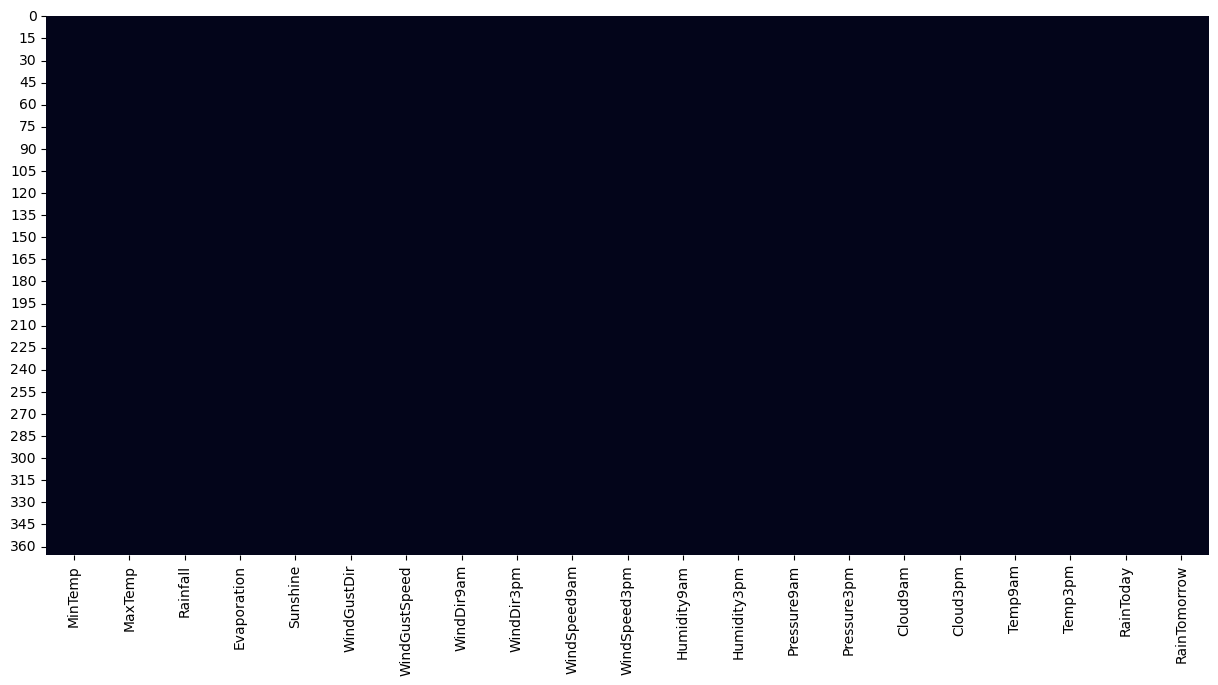

In [6]:
missingvals = Matrix(ismissing.(weather_data))
ax = Seaborn.heatmap(missingvals, xticklabels=names(weather_data), cbar=false)
ax.figure.set_size_inches(15, 7)

## Zastąpienie brakujących wartości
z użyciem MersenneTwister

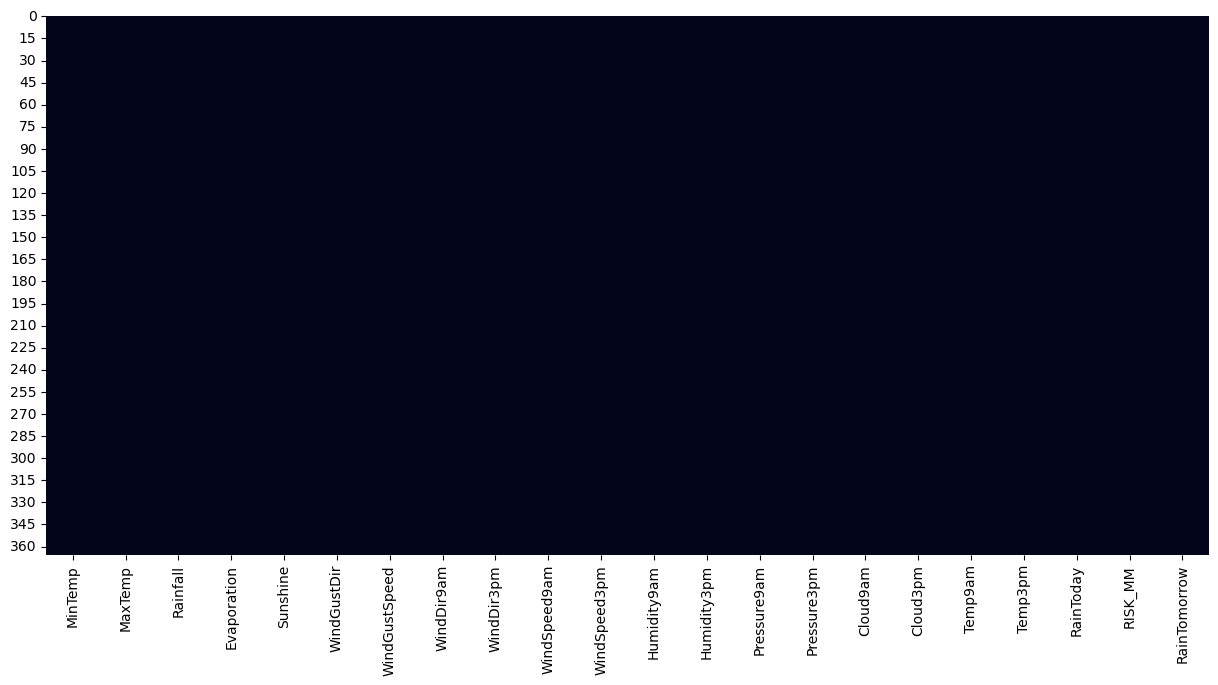

In [3]:
Impute.srs!(weather_data; rng=MersenneTwister(1234))

missingvals = ismissing.(weather_data)
missingvals = Matrix(ismissing.(weather_data))
ax = Seaborn.heatmap(missingvals, xticklabels=names(weather_data), cbar=false)
ax.figure.set_size_inches(15, 7)

## Usunięcie kolumny Risk_MM

In [5]:
select!(weather_data, Not(:RISK_MM))

LoadError: ArgumentError: column name :RISK_MM not found in the data frame

## Wykres korelacji Pearsona czynników liczbowych

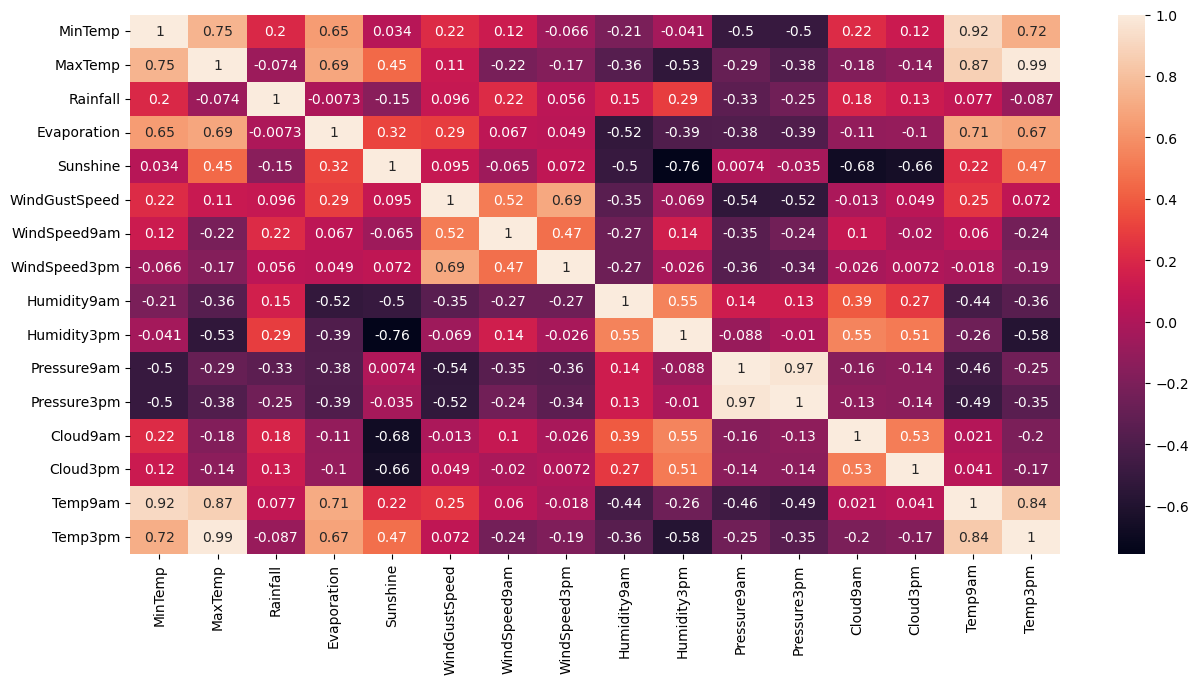

In [10]:
weather_corr = select(weather_data,
    Not([:WindGustDir, :WindDir9am, :WindDir3pm, :RainToday, :RainTomorrow]))

cm = pairwise(cor, eachcol(weather_corr))
ax = Seaborn.heatmap(cm, annot=true,
    xticklabels=names(weather_corr), yticklabels=names(weather_corr))
ax.figure.set_size_inches(15, 7)

## Zależność temperatury o godz. 9:00 od minimalnej temperatury

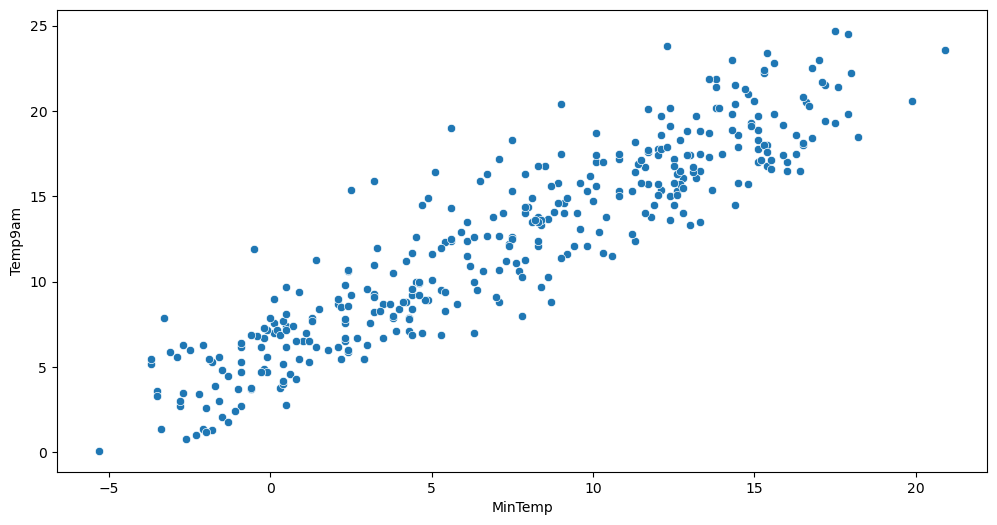

In [9]:
ax = Seaborn.scatterplot(x=weather_data.MinTemp,y=weather_data.Temp9am)
ax.set(xlabel="MinTemp", ylabel="Temp9am")
ax.figure.set_size_inches(12, 6)

## Zależność temperatury o godz. 15:00 od maksymalnej temperatury

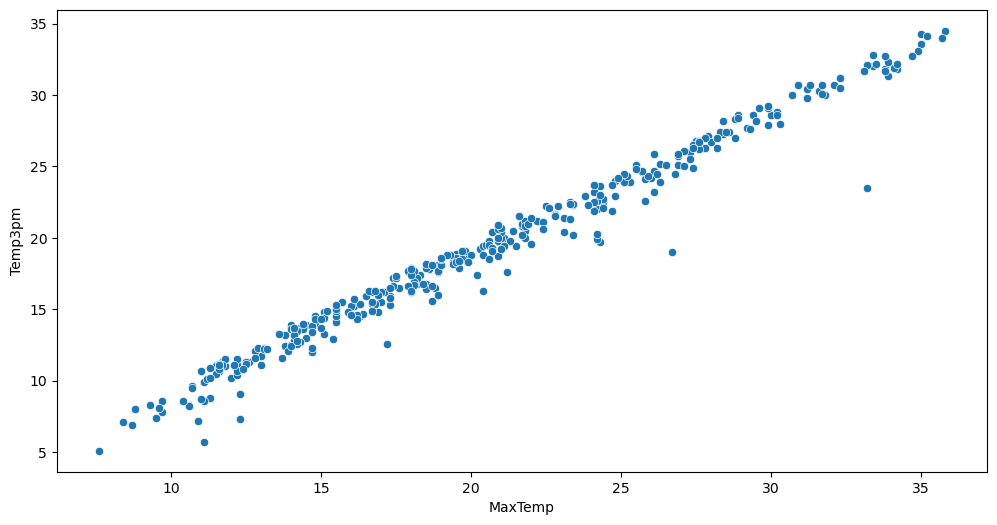

In [176]:
ax = Seaborn.scatterplot(x=weather_data.MaxTemp,y=weather_data.Temp3pm)
ax.set(xlabel="MaxTemp", ylabel="Temp3pm")
ax.figure.set_size_inches(12, 6)

## Zależność  temperatury o godz. 15.00 od nasłonecznienia

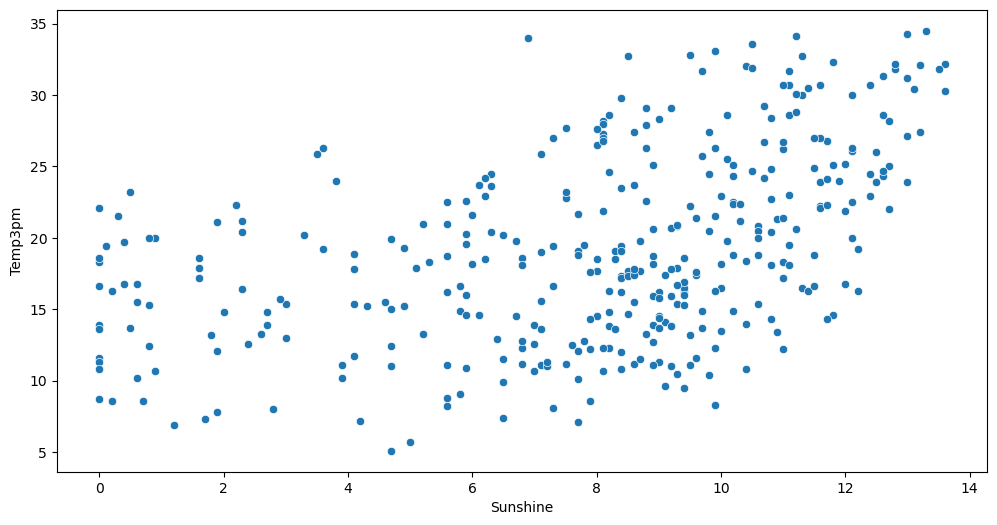

In [177]:
ax = Seaborn.scatterplot(x=weather_data.Sunshine,y=weather_data.Temp3pm)
ax.set(xlabel="Sunshine", ylabel="Temp3pm")
ax.figure.set_size_inches(12, 6)

## Histogramy rozkładu prędkości wiatru

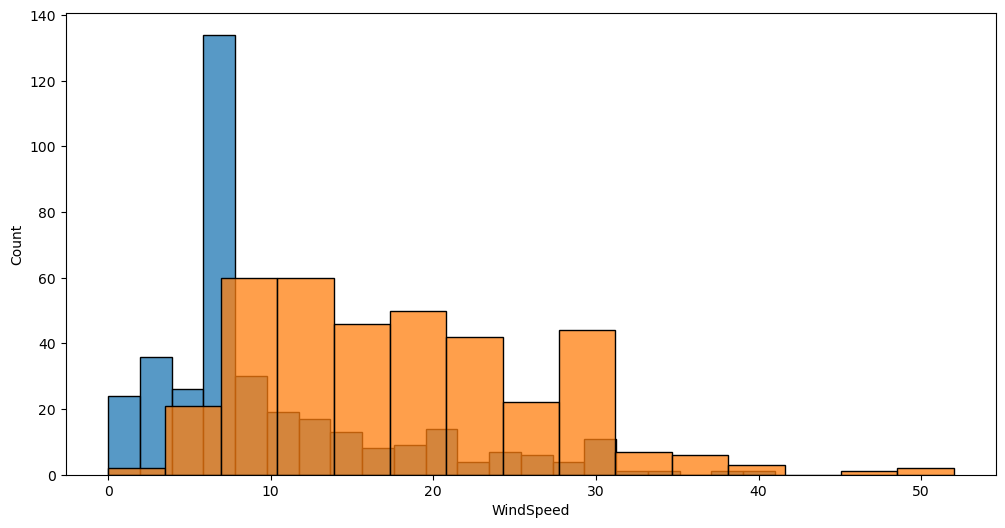

1-element Vector{PyCall.PyObject}:
 PyObject Text(0.5, 24.0, 'WindSpeed')

In [33]:
ax = Seaborn.histplot(weather_data.WindSpeed9am)
ax.figure.set_size_inches(12, 6)
Seaborn.histplot(weather_data.WindSpeed3pm, ax=ax)
ax.set(xlabel="WindSpeed")

## Histogram rozkładu kierunku wiania wiatru o 9:00 i o 15:00

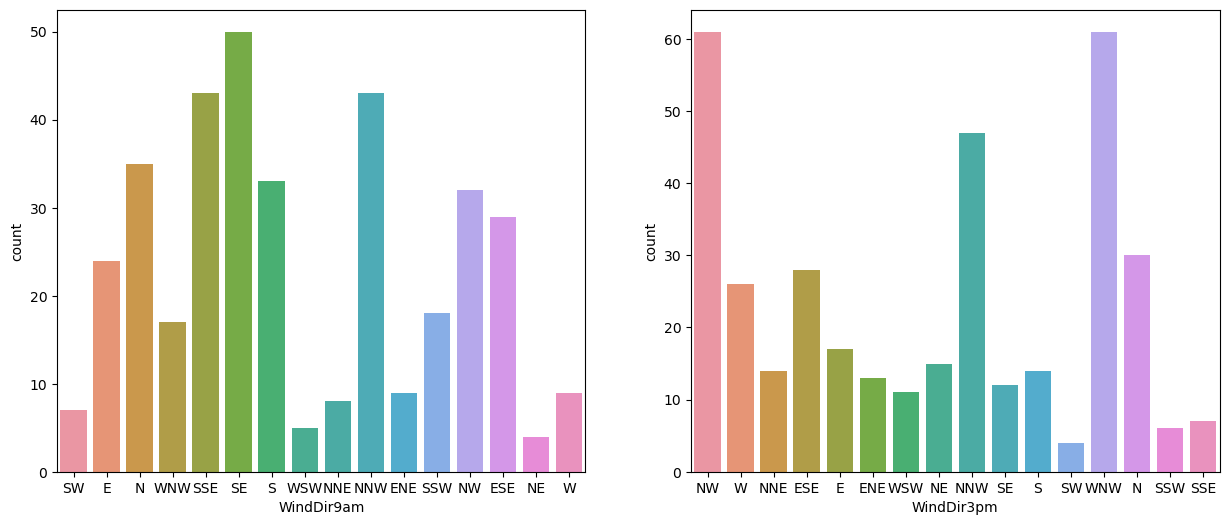

1-element Vector{PyCall.PyObject}:
 PyObject Text(0.5, 24.0, 'WindDir3pm')

In [209]:
fig, ax = subplots(1,2,figsize= (15,6))
Seaborn.countplot(x=weather_data.WindDir9am, ax=ax[1])
ax[1].set(xlabel="WindDir9am")

Seaborn.countplot(x=weather_data.WindDir3pm, ax=ax[2])
ax[2].set(xlabel="WindDir3pm")

## Zależność parowania od wilgotności o 15:00

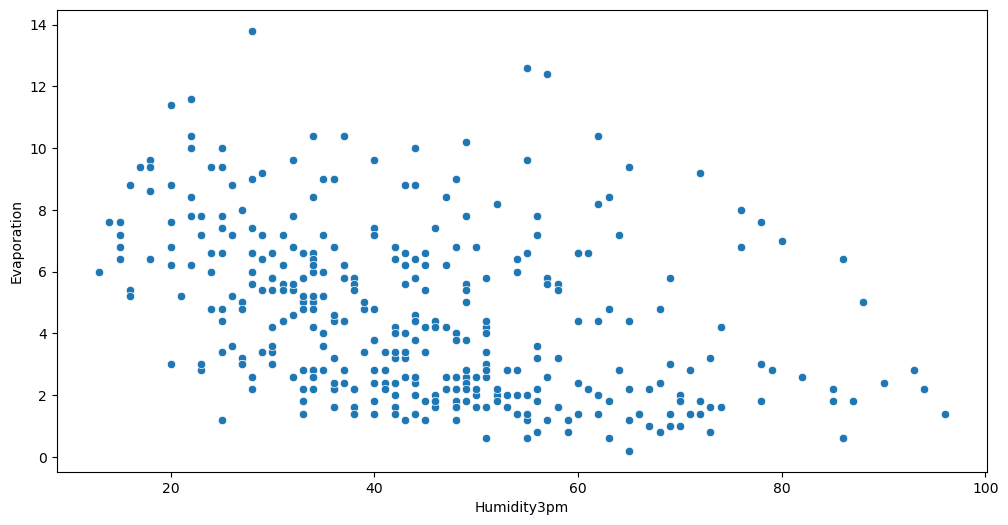

In [174]:
ax = Seaborn.scatterplot(x=weather_data.Humidity3pm,y=weather_data.Evaporation)
ax.set(xlabel="Humidity3pm", ylabel="Evaporation")
ax.figure.set_size_inches(12, 6)

## Histogramy rozkładu ciśnienia (o 9:00 i 15:00)

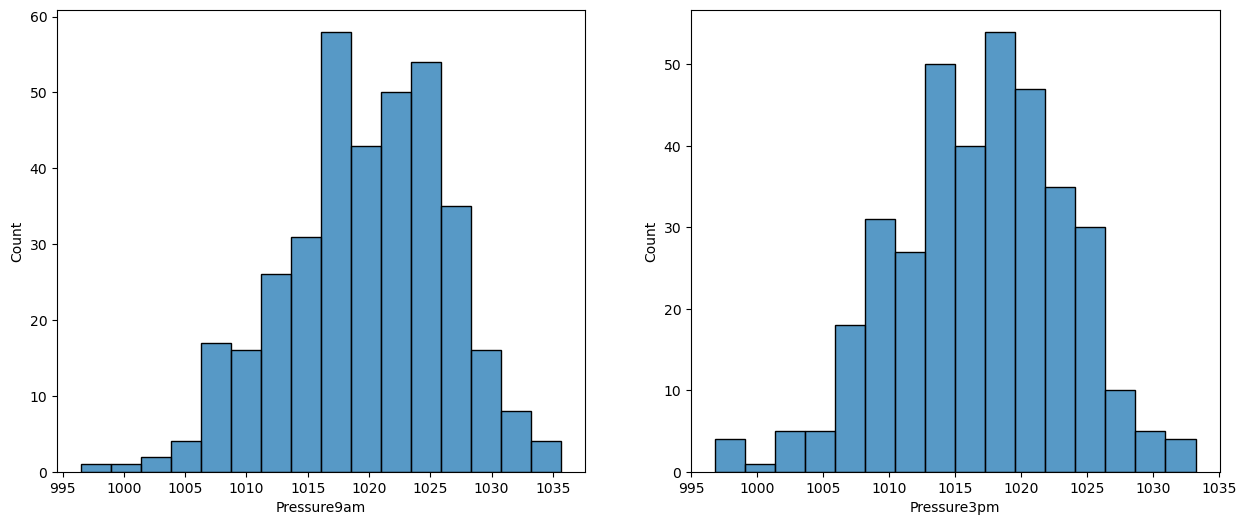

1-element Vector{PyCall.PyObject}:
 PyObject Text(0.5, 24.0, 'Pressure3pm')

In [34]:
fig, ax = subplots(1,2,figsize= (15,6))
Seaborn.histplot(weather_data.Pressure9am, ax=ax[1])
Seaborn.histplot(weather_data.Pressure3pm, ax=ax[2])
ax[1].set(xlabel="Pressure9am")
ax[2].set(xlabel="Pressure3pm")

## Zależność minimalnej temperatury od ciśnienia o 9:00

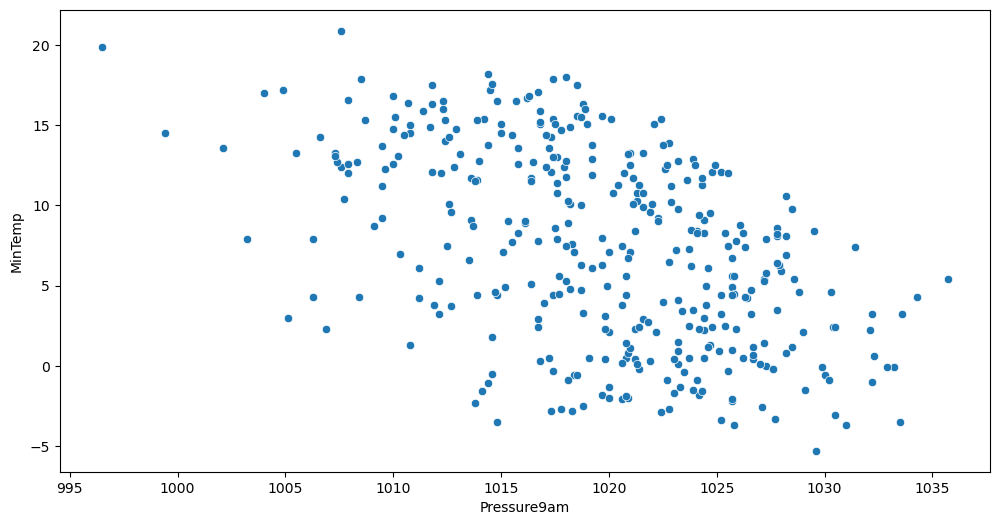

In [178]:
ax = Seaborn.scatterplot(x=weather_data.Pressure9am,y=weather_data.MinTemp)
ax.set(xlabel="Pressure9am", ylabel="MinTemp")
ax.figure.set_size_inches(12, 6)

## Zależność maksymalnej temperatury od ciśnienia o 15:00

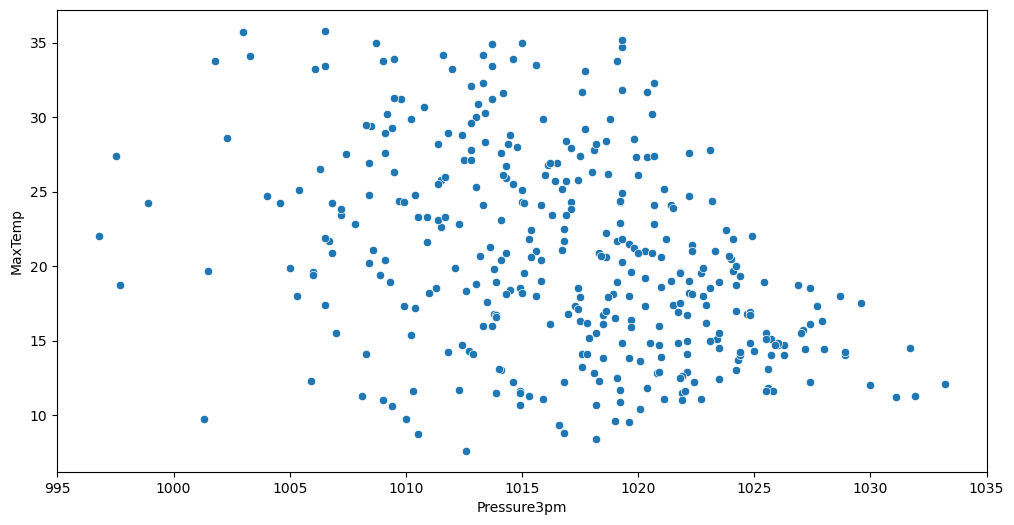

In [179]:
ax = Seaborn.scatterplot(x=weather_data.Pressure3pm,y=weather_data.MaxTemp)
ax.set(xlabel="Pressure3pm", ylabel="MaxTemp")
ax.figure.set_size_inches(12, 6)

## Histogramy rozkładu zachmurzenia (o 9:00 i 15:00) 

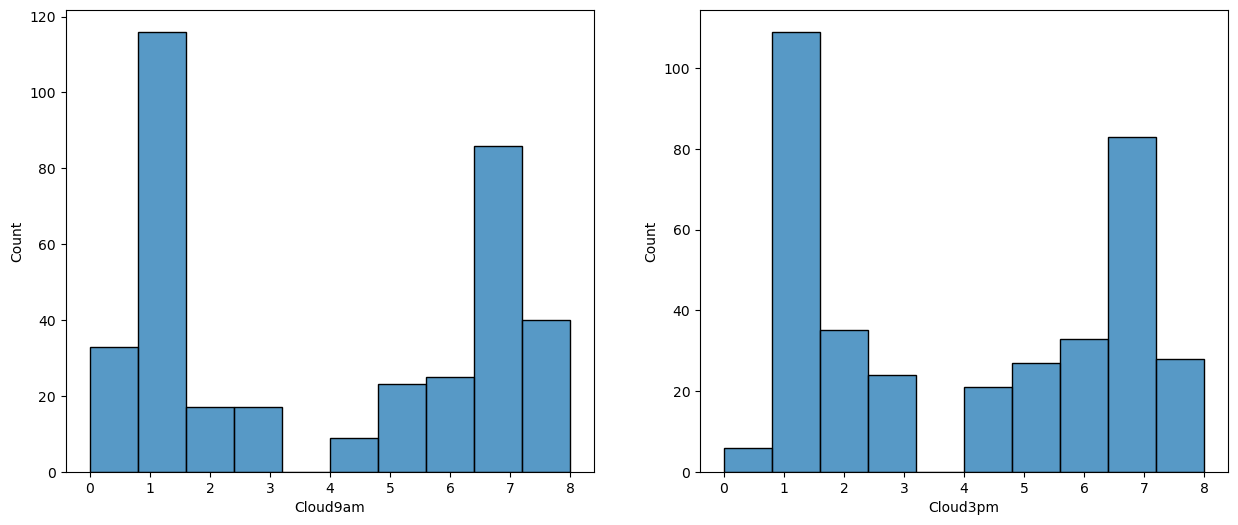

1-element Vector{PyCall.PyObject}:
 PyObject Text(0.5, 24.0, 'Cloud3pm')

In [6]:
fig, ax = subplots(1,2,figsize= (15,6))
Seaborn.histplot(weather_data.Cloud9am, ax=ax[1])
Seaborn.histplot(weather_data.Cloud3pm, ax=ax[2])
ax[1].set(xlabel="Cloud9am")
ax[2].set(xlabel="Cloud3pm")

## Zależność wilgotności od zachmurzenia o 9:00 i o 15:00

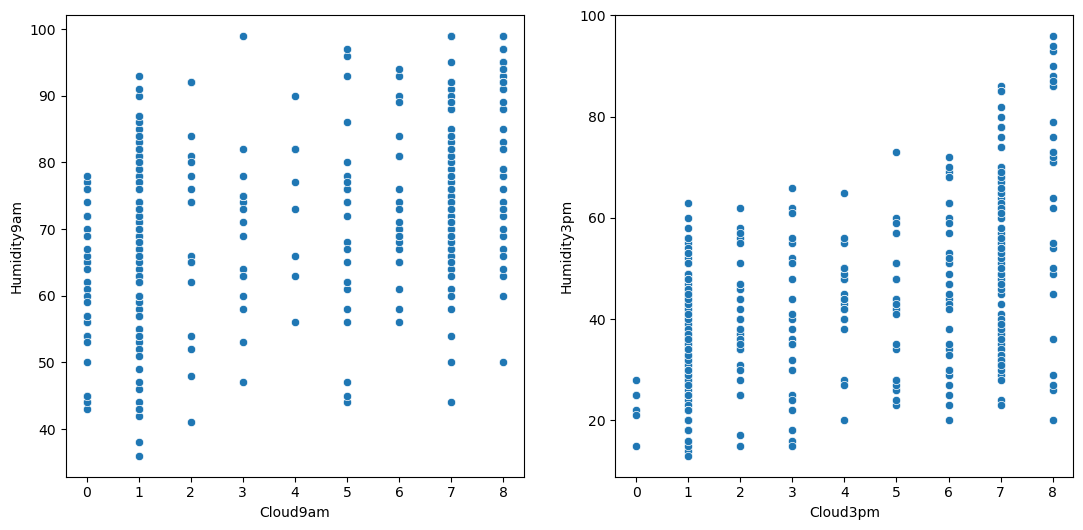

2-element Vector{PyCall.PyObject}:
 PyObject Text(0.5, 24.0, 'Cloud3pm')
 PyObject Text(573.5454545454545, 0.5, 'Humidity3pm')

In [206]:
fig, ax = subplots(1,2,figsize= (13,6))

Seaborn.scatterplot(x=weather_data.Cloud9am,y=weather_data.Humidity9am, ax=ax[1])
ax[1].set(xlabel="Cloud9am", ylabel="Humidity9am")

Seaborn.scatterplot(x=weather_data.Cloud3pm,y=weather_data.Humidity3pm, ax=ax[2])
ax[2].set(xlabel="Cloud3pm", ylabel="Humidity3pm")

## Algorytm XGboost


1. Inicjalizacja modelu

2. Obliczanie błędów

3. Tworzenie nowego modelu

4. Aktualizacja prognoz

5. Obliczanie gradientu

6. Aktualizacja modelu

7. Powtarzanie procesu

8. Końcowa prognoza

## Przykładowe drzewo

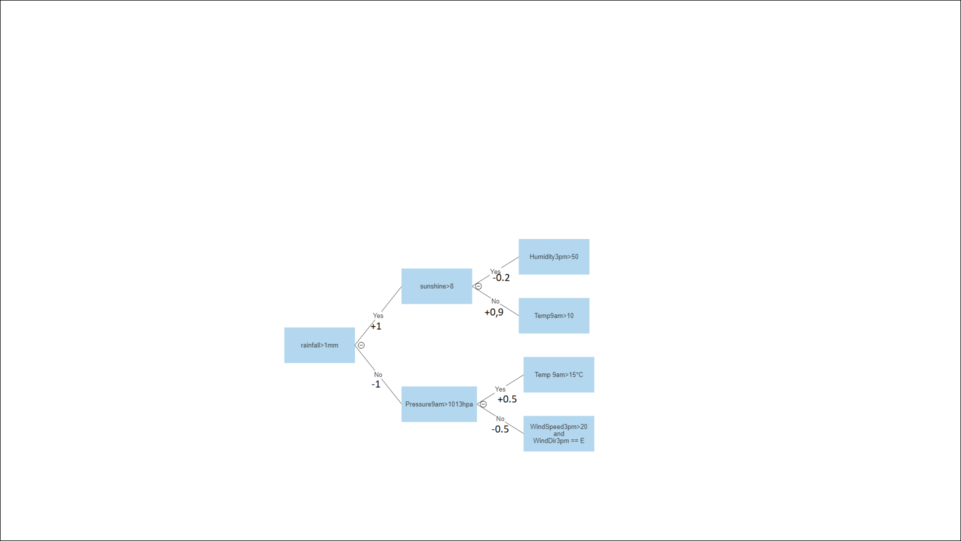

In [7]:
using Images
drzewo1 = load("drzewo1.png")

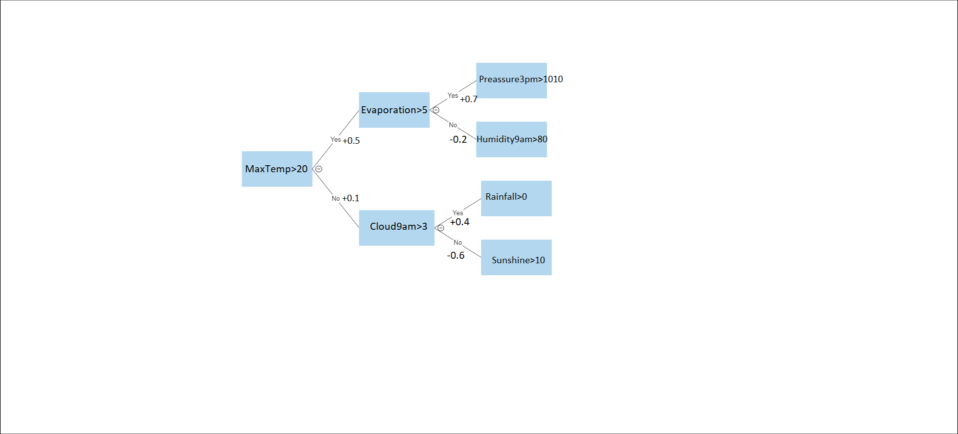

In [18]:
drzewo2 = load("drzewo2.png")

## DataFrameMapping

In [7]:
mapper = DataFrameMapper([([:MinTemp], StandardScaler()),
([:MaxTemp], StandardScaler()),
([:Rainfall], StandardScaler()),
([:Evaporation], StandardScaler()),
([:Sunshine], StandardScaler()),
([:WindSpeed9am], StandardScaler()),
([:WindSpeed3pm], StandardScaler()),
([:Humidity9am], StandardScaler()),
([:Humidity3pm], StandardScaler()),
([:Pressure9am], StandardScaler()),
([:Pressure3pm], StandardScaler()),
([:Cloud9am], StandardScaler()),
([:Cloud3pm], StandardScaler()),
([:Temp9am], StandardScaler()),
([:Temp3pm], StandardScaler()),
(:WindGustDir, LabelBinarizer()),
([:WindGustSpeed], StandardScaler()),
(:WindDir9am, LabelBinarizer()),
(:WindDir3pm, LabelBinarizer()),
([:WindSpeed9am], StandardScaler()),
([:WindSpeed3pm], StandardScaler()),
([:Humidity9am], StandardScaler()),
([:Humidity3pm], StandardScaler()),
([:Pressure9am], StandardScaler()),
([:Pressure3pm], StandardScaler()),
([:Cloud9am], StandardScaler()),
([:Cloud3pm], StandardScaler()),
([:Temp9am], StandardScaler()),
([:Temp3pm], StandardScaler()),
(:RainToday, LabelBinarizer()),
(:RainTomorrow, LabelBinarizer())]
)


data_matrix = fit_transform!(mapper, copy(weather_data))

366×76 Matrix{Float64}:
  0.122047    0.561221   -0.338485  …   0.363059     0.658867   0.0  1.0
  1.11913     0.950363    0.514591      0.914353     0.975549   1.0  1.0
  1.06927     0.426518    0.514591      0.540896     0.146145   1.0  1.0
  1.0028     -0.755874    9.09274       0.203006    -0.77374    1.0  1.0
  0.055575   -0.666072    0.325018     -0.223802    -0.577699   1.0  0.0
 -0.177077   -0.546336   -0.338485  …  -0.25937     -0.668179   0.0  0.0
 -0.193695   -0.351765   -0.291092      0.00738557  -0.291177   0.0  0.0
  0.171901   -0.531369   -0.338485     -0.0459655   -0.562619   0.0  0.0
  0.254991   -0.157194   -0.338485      0.309708    -0.0498961  0.0  1.0
  0.188519    0.336716    3.50036       0.167439     0.372346   1.0  0.0
  0.304845    0.695924   -0.338485  …   0.398626     0.719188   0.0  0.0
  0.205137    1.01023    -0.291092      0.789867     1.02079    0.0  0.0
  0.471026    1.10003    -0.338485      0.825435     1.18667    0.0  0.0
  ⋮                        

## Ewaluacja XGBoost - XGBoost.jl

In [9]:
using ScikitLearn.CrossValidation: train_test_split
using XGBoost
using XGBoost: predict

X, y = data_matrix[:,1:end-1], data_matrix[:,end]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
xg_cl = xgboost((X_train, y_train), num_round=5, max_depth=6, objective="binary:logistic")
preds = predict(xg_cl, X_test)
acuracy = sum(round.(preds) .== y_test) / length(y_test)

[ Info: XGBoost: starting training.
[ Info: [1]	train-logloss:0.50952637498266995
[ Info: [2]	train-logloss:0.39945564931258559
[ Info: [3]	train-logloss:0.32501358201261610
[ Info: [4]	train-logloss:0.27159830782329664
[ Info: [5]	train-logloss:0.23232853531953879
[ Info: Training rounds complete.


0.8727272727272727

# Podejście przy użyciu MLJ.jl
### Naukowe typy zmiennych

In [8]:
using MLJ


schema(weather_data)

┌───────────────┬────────────────────────────┬─────────────────────────┐
│ names         │ scitypes                   │ types                   │
├───────────────┼────────────────────────────┼─────────────────────────┤
│ MinTemp       │ Continuous                 │ Float64                 │
│ MaxTemp       │ Continuous                 │ Float64                 │
│ Rainfall      │ Continuous                 │ Float64                 │
│ Evaporation   │ Continuous                 │ Float64                 │
│ Sunshine      │ Union{Missing, Continuous} │ Union{Missing, Float64} │
│ WindGustDir   │ Union{Missing, Textual}    │ Union{Missing, String3} │
│ WindGustSpeed │ Union{Missing, Count}      │ Union{Missing, Int64}   │
│ WindDir9am    │ Union{Missing, Textual}    │ Union{Missing, String3} │
│ WindDir3pm    │ Union{Missing, Textual}    │ Union{Missing, String3} │
│ WindSpeed9am  │ Union{Missing, Count}      │ Union{Missing, Int64}   │
│ WindSpeed3pm  │ Count                      │ Int6

## Mapowanie do typów naukowych

In [9]:
coerce!(weather_data, :WindGustDir => Multiclass, :WindGustSpeed => Continuous,
    :WindDir9am => Multiclass, :WindDir3pm => Multiclass, :WindSpeed9am => Continuous, :WindSpeed3pm => Continuous,
    :RainToday => OrderedFactor, :RainTomorrow => OrderedFactor)

schema(weather_data)

┌ Info: Trying to coerce from `Union{Missing, String3}` to `Multiclass`.
└ Coerced to `Union{Missing,Multiclass}` instead.
┌ Info: Trying to coerce from `Union{Missing, Int64}` to `Continuous`.
└ Coerced to `Union{Missing,Continuous}` instead.
┌ Info: Trying to coerce from `Union{Missing, String3}` to `Multiclass`.
└ Coerced to `Union{Missing,Multiclass}` instead.
┌ Info: Trying to coerce from `Union{Missing, String3}` to `Multiclass`.
└ Coerced to `Union{Missing,Multiclass}` instead.
┌ Info: Trying to coerce from `Union{Missing, Int64}` to `Continuous`.
└ Coerced to `Union{Missing,Continuous}` instead.


┌───────────────┬────────────────────────────────┬──────────────────────────────
│ names         │ scitypes                       │ types                       ⋯
├───────────────┼────────────────────────────────┼──────────────────────────────
│ MinTemp       │ Continuous                     │ Float64                     ⋯
│ MaxTemp       │ Continuous                     │ Float64                     ⋯
│ Rainfall      │ Continuous                     │ Float64                     ⋯
│ Evaporation   │ Continuous                     │ Float64                     ⋯
│ Sunshine      │ Union{Missing, Continuous}     │ Union{Missing, Float64}     ⋯
│ WindGustDir   │ Union{Missing, Multiclass{16}} │ Union{Missing, CategoricalV ⋯
│ WindGustSpeed │ Union{Missing, Continuous}     │ Union{Missing, Float64}     ⋯
│ WindDir9am    │ Union{Missing, Multiclass{16}} │ Union{Missing, CategoricalV ⋯
│ WindDir3pm    │ Union{Missing, Multiclass{16}} │ Union{Missing, CategoricalV ⋯
│ WindSpeed9am  │ Union{Miss

## Podział danych na X i y

In [10]:
y, X =  MLJ.unpack(weather_data, ==(:RainTomorrow), rng=123)

(CategoricalArrays.CategoricalValue{String3, UInt32}[String3("No"), String3("No"), String3("No"), String3("No"), String3("Yes"), String3("No"), String3("No"), String3("No"), String3("No"), String3("No")  …  String3("No"), String3("No"), String3("No"), String3("Yes"), String3("No"), String3("No"), String3("No"), String3("No"), String3("No"), String3("Yes")], 366×20 DataFrame
 Row │ MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  WindGustDir  WindGus ⋯
     │ Float64  Float64  Float64   Float64      Float64?  Cat…?        Float64 ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │     9.0     20.6       0.0          9.0       6.2  ENE                  ⋯
   2 │    -0.5     21.6       0.0          5.0       9.9  NW
   3 │    14.9     28.8       0.0          5.8       8.1  NNE
   4 │    13.3     26.5       6.6          3.8      11.8  NW
   5 │     9.8     14.4       0.8          0.6       0.0  ESE                  ⋯
   6 │    -2.1     13.8       0.2 

## Transformacja danych
### ContinuousEncoder - zmienia wszystkie elementy na typ Continuous według protokołu:
- Jeśli typ to Continuous - zachowuje go
- Dla Multiclass, OrderedFactor stosuje OneHotEncoder
- Dla Count zamienia na Continous

In [11]:
pipe = (MLJ.FillImputer() |> MLJ.ContinuousEncoder())

mach_transf = machine(pipe, X) |> MLJ.fit!

X = MLJ.transform(mach_transf, X)

[ Info: Training machine(UnsupervisedPipeline(fill_imputer = FillImputer(features = Symbol[], …), …), …).
[ Info: Training machine(:fill_imputer, …).
[ Info: Training machine(:continuous_encoder, …).


Row,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir__E,WindGustDir__ENE,WindGustDir__ESE,WindGustDir__N,WindGustDir__NE,WindGustDir__NNE,WindGustDir__NNW,WindGustDir__NW,WindGustDir__S,WindGustDir__SE,WindGustDir__SSE,WindGustDir__SSW,WindGustDir__SW,WindGustDir__W,WindGustDir__WNW,WindGustDir__WSW,WindGustSpeed,WindDir9am__E,WindDir9am__ENE,WindDir9am__ESE,WindDir9am__N,WindDir9am__NE,WindDir9am__NNE,WindDir9am__NNW,WindDir9am__NW,WindDir9am__S,WindDir9am__SE,WindDir9am__SSE,WindDir9am__SSW,WindDir9am__SW,WindDir9am__W,WindDir9am__WNW,WindDir9am__WSW,WindDir3pm__E,WindDir3pm__ENE,WindDir3pm__ESE,WindDir3pm__N,WindDir3pm__NE,WindDir3pm__NNE,WindDir3pm__NNW,WindDir3pm__NW,WindDir3pm__S,WindDir3pm__SE,WindDir3pm__SSE,WindDir3pm__SSW,WindDir3pm__SW,WindDir3pm__W,WindDir3pm__WNW,WindDir3pm__WSW,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,9.0,20.6,0.0,9.0,6.2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11.0,11.0,54.0,28.0,1022.3,1018.6,7.0,5.0,11.4,18.5,1.0
2,-0.5,21.6,0.0,5.0,9.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,48.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,26.0,44.0,27.0,1014.6,1010.9,7.0,5.0,11.9,21.5,1.0
3,14.9,28.8,0.0,5.8,8.1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,11.0,71.0,44.0,1018.2,1014.5,7.0,2.0,19.1,27.0,1.0
4,13.3,26.5,6.6,3.8,11.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,20.0,26.0,74.0,40.0,1007.3,1006.3,5.0,2.0,18.8,25.1,2.0
5,9.8,14.4,0.8,0.6,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,11.0,99.0,86.0,1028.5,1027.2,8.0,8.0,12.1,13.6,1.0
6,-2.1,13.8,0.2,1.8,9.5,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,69.0,40.0,1020.6,1019.6,0.0,1.0,6.3,13.2,1.0
7,0.3,17.0,0.0,2.2,5.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,31.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,6.0,24.0,99.0,52.0,1021.9,1018.6,8.0,1.0,3.8,16.2,1.0
8,13.3,31.7,0.2,7.8,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,44.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,6.0,28.0,80.0,23.0,1021.6,1017.6,2.0,5.0,17.5,30.7,1.0
9,2.4,17.3,0.0,2.2,11.3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4.0,6.0,67.0,33.0,1030.5,1027.7,1.0,1.0,10.7,16.5,1.0


In [12]:
(X_train, X_test), (y_train, y_test)  = partition((X, y), 0.7, multi=true,  rng=123)

((256×65 DataFrame
 Row │ MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  WindGustDir__E  Wind ⋯
     │ Float64  Float64  Float64   Float64      Float64   Float64         Floa ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │    12.0     28.9       0.0          7.2       8.2             0.0       ⋯
   2 │    13.8     35.2       0.0          6.4      11.2             0.0
   3 │    14.3     26.7       0.0          7.2       7.1             0.0
   4 │     5.3     11.7       2.0          3.6       5.6             0.0
   5 │     7.5     20.9       0.0          6.6       8.7             0.0       ⋯
   6 │    12.5     19.9       0.0          8.4       5.3             0.0
   7 │     9.0     25.5       0.0          5.6      10.2             0.0
   8 │     3.2     18.7       0.0          2.6      11.1             0.0
   9 │     1.2     14.5       0.0          1.2       8.9             0.0       ⋯
  10 │     5.3     21.0       0.0          4.6       6.3 

## Pasujące modele

In [15]:
MLJ.models(matching(X_train, y_train))

52-element Vector{NamedTuple{(:name, :package_name, :is_supervised, :abstract_type, :deep_properties, :docstring, :fit_data_scitype, :human_name, :hyperparameter_ranges, :hyperparameter_types, :hyperparameters, :implemented_methods, :inverse_transform_scitype, :is_pure_julia, :is_wrapper, :iteration_parameter, :load_path, :package_license, :package_url, :package_uuid, :predict_scitype, :prediction_type, :reporting_operations, :reports_feature_importances, :supports_class_weights, :supports_online, :supports_training_losses, :supports_weights, :transform_scitype, :input_scitype, :target_scitype, :output_scitype)}}:
 (name = AdaBoostClassifier, package_name = MLJScikitLearnInterface, ... )
 (name = AdaBoostStumpClassifier, package_name = DecisionTree, ... )
 (name = BaggingClassifier, package_name = MLJScikitLearnInterface, ... )
 (name = BayesianLDA, package_name = MLJScikitLearnInterface, ... )
 (name = BayesianLDA, package_name = MultivariateStats, ... )
 (name = BayesianQDA, package_

## Instancjonalizacja modelu i jego uczenie

In [13]:
XGBoostClassifier = @load XGBoostClassifier pkg=XGBoost
xgb_model = XGBoostClassifier(max_depth = 8, num_round = 8, objective="binary:logistic")
mach_xgb = machine(xgb_model, X_train, y_train)

MLJ.fit!(mach_xgb, verbosity=1)

[ Info: For silent loading, specify `verbosity=0`. 


import MLJXGBoostInterface ✔


[ Info: Training machine(XGBoostClassifier(test = 1, …), …).
[ Info: XGBoost: starting training.
[ Info: [1]	train-logloss:0.50450016011018306
[ Info: [2]	train-logloss:0.39549834863282740
[ Info: [3]	train-logloss:0.32192377897445112
[ Info: [4]	train-logloss:0.26820918271550909
[ Info: [5]	train-logloss:0.22374031483195722
[ Info: [6]	train-logloss:0.19134860634221695
[ Info: [7]	train-logloss:0.16543824944528751
[ Info: [8]	train-logloss:0.14347034726233687
[ Info: Training rounds complete.


trained Machine; caches model-specific representations of data
  model: XGBoostClassifier(test = 1, …)
  args: 
    1:	Source @932 ⏎ Table{AbstractVector{Continuous}}
    2:	Source @220 ⏎ AbstractVector{OrderedFactor{2}}


## Wyniki

In [17]:
ypred = MLJ.predict_mode(mach_xgb, X_test)

110-element CategoricalArrays.CategoricalArray{String3,1,UInt32}:
 String3("No")
 String3("No")
 String3("No")
 String3("No")
 String3("No")
 String3("No")
 String3("No")
 String3("No")
 String3("No")
 String3("No")
 String3("No")
 String3("No")
 String3("No")
 ⋮
 String3("No")
 String3("No")
 String3("No")
 String3("Yes")
 String3("No")
 String3("No")
 String3("No")
 String3("No")
 String3("No")
 String3("No")
 String3("No")
 String3("Yes")

In [18]:
round(accuracy(ypred, y_test), sigdigits=3)

0.864

## Cross validation

In [19]:
params(xgb_model)  # jakie hyperparametry możemy zmieniać

(test = 1,
 num_round = 8,
 booster = "gbtree",
 disable_default_eval_metric = 0,
 eta = 0.3,
 num_parallel_tree = 1,
 gamma = 0.0,
 max_depth = 8,
 min_child_weight = 1.0,
 max_delta_step = 0.0,
 subsample = 1.0,
 colsample_bytree = 1.0,
 colsample_bylevel = 1.0,
 colsample_bynode = 1.0,
 lambda = 1.0,
 alpha = 0.0,
 tree_method = "auto",
 sketch_eps = 0.03,
 scale_pos_weight = 1.0,
 updater = nothing,
 refresh_leaf = 1,
 process_type = "default",
 grow_policy = "depthwise",
 max_leaves = 0,
 max_bin = 256,
 predictor = "cpu_predictor",
 sample_type = "uniform",
 normalize_type = "tree",
 rate_drop = 0.0,
 one_drop = 0,
 skip_drop = 0.0,
 feature_selector = "cyclic",
 top_k = 0,
 tweedie_variance_power = 1.5,
 objective = "binary:logistic",
 base_score = 0.5,
 watchlist = nothing,
 nthread = 1,
 importance_type = "gain",
 seed = nothing,
 validate_parameters = false,)

In [14]:
num_round_vals = [10, 50,70, 100]
accuracies = []

for val in num_round_vals
    xgb_model = XGBoostClassifier(max_depth = 8, num_round = val, objective="binary:logistic")
    append!(accuracies, 
        MLJ.evaluate(xgb_model, X, y, resampling=CV(nfolds=3), measure=Accuracy(), verbosity=1).measurement)
end

DataFrame(Ilość_rund=num_round_vals, Trafność=accuracies)

Evaluating over 3 folds: 100%[=========================] Time: 0:00:04
Evaluating over 3 folds: 100%[=========================] Time: 0:00:00


Row,Ilość_rund,Trafność
,Int64,Any
1,10,0.846995
2,50,0.86612
3,70,0.860656
4,100,0.863388


In [15]:
eta_vals = [0.001, 0.01, 0.1]
accuracies = []

for val in eta_vals
    xgb_model = XGBoostClassifier(max_depth = 8, eta=val, objective="binary:logistic")
    append!(accuracies, 
        MLJ.evaluate(xgb_model, X, y, resampling=CV(nfolds=3), measure=Accuracy(), verbosity=1).measurement)
end

DataFrame(Eta=eta_vals, Trafność=accuracies)

Evaluating over 3 folds: 100%[=========================] Time: 0:00:00
Evaluating over 3 folds: 100%[=========================] Time: 0:00:00
Evaluating over 3 folds: 100%[=========================] Time: 0:00:00


Row,Eta,Trafność
,Float64,Any
1,0.001,0.827869
2,0.01,0.825137
3,0.1,0.857923


## Szukanie najlepszych parametrów - RandomSearch

In [16]:
parameters =[
    range(xgb_model, :eta, lower=0.05, upper=1.0, unit=0.05),
    range(xgb_model, :max_depth, lower=3, upper=10, unit=1),
    range(xgb_model, :min_child_weight, lower=0, upper=6, unit=2),
    range(xgb_model, :gamma, lower=0.0, upper=0.5, unit=0.1),
    range(xgb_model, :num_round, lower=10, upper=100),
    range(xgb_model, :subsample, lower=0.6, upper=1.0),
    range(xgb_model, :colsample_bytree, lower=0.6, upper=1.0)
]

tm = TunedModel(
    model=xgb_model,
    ranges=parameters,
#     tuning=Grid(resolution=20, goal=100),
    tuning=RandomSearch(rng=87),
    resampling=CV(nfolds=3),
    operation=predict_mode,
    measure=Accuracy(),
    n=100 # ilość modeli
)

mach_tm = machine(tm, X_train, y_train)
MLJ.fit!(mach_tm)

ypred = MLJ.predict_mode(mach_tm, X_test)
round(accuracy(ypred, y_test), sigdigits=3)

[ Info: Training machine(ProbabilisticTunedModel(model = XGBoostClassifier(test = 1, …), …), …).
[ Info: Attempting to evaluate 100 models.
Evaluating over 100 metamodels: 100%[=========================] Time: 0:00:04


0.9

## Najlepsze znalezione parametry

In [23]:
fitted_params(mach_tm).best_model

XGBoostClassifier(
  test = 1, 
  num_round = 72, 
  booster = "gbtree", 
  disable_default_eval_metric = 0, 
  eta = 0.42837385182774523, 
  num_parallel_tree = 1, 
  gamma = 0.4272674581020033, 
  max_depth = 10, 
  min_child_weight = 1.789248801105161, 
  max_delta_step = 0.0, 
  subsample = 0.8385286937296602, 
  colsample_bytree = 0.8444468372152923, 
  colsample_bylevel = 1.0, 
  colsample_bynode = 1.0, 
  lambda = 1.0, 
  alpha = 0.0, 
  tree_method = "auto", 
  sketch_eps = 0.03, 
  scale_pos_weight = 1.0, 
  updater = nothing, 
  refresh_leaf = 1, 
  process_type = "default", 
  grow_policy = "depthwise", 
  max_leaves = 0, 
  max_bin = 256, 
  predictor = "cpu_predictor", 
  sample_type = "uniform", 
  normalize_type = "tree", 
  rate_drop = 0.0, 
  one_drop = 0, 
  skip_drop = 0.0, 
  feature_selector = "cyclic", 
  top_k = 0, 
  tweedie_variance_power = 1.5, 
  objective = "binary:logistic", 
  base_score = 0.5, 
  watchlist = nothing, 
  nthread = 1, 
  importance_type = "

In [90]:
report(mach_tm)

(best_model = XGBoostClassifier(test = 1, …),
 best_history_entry = (model = XGBoostClassifier(test = 1, …),
                       measure = [Accuracy()],
                       measurement = [0.8635658914728682],
                       per_fold = [[0.7906976744186046, 0.9058823529411765, 0.8941176470588236]],),
 history = NamedTuple{(:model, :measure, :measurement, :per_fold), Tuple{MLJXGBoostInterface.XGBoostClassifier, Vector{Accuracy}, Vector{Float64}, Vector{Vector{Float64}}}}[(model = XGBoostClassifier(test = 1, …), measure = [Accuracy()], measurement = [0.8635202918376653], per_fold = [[0.8023255813953488, 0.9294117647058824, 0.8588235294117648]]), (model = XGBoostClassifier(test = 1, …), measure = [Accuracy()], measurement = [0.8322845417236663], per_fold = [[0.7674418604651163, 0.8705882352941177, 0.8588235294117648]]), (model = XGBoostClassifier(test = 1, …), measure = [Accuracy()], measurement = [0.8518011855905153], per_fold = [[0.7906976744186046, 0.8941176470588236, 0.87

## Macierz błędów
####  Predicted, Ground Truth -> znaczenie

- No, No -> prawdziwnie negatywne (TN)
- Yes, No -> fałszywie pozytywne (FP)
- No, Yes -> fałszywie negatywne (FN)
- Yes, Yes -> prawdziwe pozytywne (TP)

In [17]:
y_test = String.(y_test)
conf_mat = MLJ.confusion_matrix(ypred, y_test)

┌ Warning: The classes are un-ordered,
│ using: negative='No' and positive='Yes'.
│ To suppress this warning, consider coercing to OrderedFactor.
└ @ MLJBase ~/.julia/packages/MLJBase/5cxU0/src/measures/confusion_matrix.jl:116


              ┌───────────────────────────┐
              │       Ground Truth        │
┌─────────────┼─────────────┬─────────────┤
│  Predicted  │     No      │     Yes     │
├─────────────┼─────────────┼─────────────┤
│     No      │     86      │     10      │
├─────────────┼─────────────┼─────────────┤
│     Yes     │      1      │     13      │
└─────────────┴─────────────┴─────────────┘


### Accuracy = $\frac{TP+TN}{TN+FP+FN+TP}$

In [26]:
MLJ.accuracy(conf_mat)

0.9

### Precision = $\frac{TP}{FP+TP}$

In [27]:
MLJ.precision(ypred, y_test)

┌ Warning: The classes are un-ordered,
│ using: negative='No' and positive='Yes'.
│ To suppress this warning, consider coercing to OrderedFactor.
└ @ MLJBase ~/.julia/packages/MLJBase/g5E7V/src/measures/confusion_matrix.jl:116


0.9285714285714286

### Recall = $\frac{TP}{FN+TP}$

In [28]:
MLJ.recall(ypred, y_test)

┌ Warning: The classes are un-ordered,
│ using: negative='No' and positive='Yes'.
│ To suppress this warning, consider coercing to OrderedFactor.
└ @ MLJBase ~/.julia/packages/MLJBase/g5E7V/src/measures/confusion_matrix.jl:116


0.5652173913043478

### F<sub>1</sub>score= $ 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}} = \frac{2 \times TP}{2 \times TP+FP+FN}$

In [29]:
f1score(ypred, y_test)

┌ Warning: The classes are un-ordered,
│ using: negative='No' and positive='Yes'.
│ To suppress this warning, consider coercing to OrderedFactor.
└ @ MLJBase ~/.julia/packages/MLJBase/g5E7V/src/measures/confusion_matrix.jl:116


0.7027027027027027

### Matthews correlation coefficient (MCC) = $\frac{TP\times TN - FP\times FN}{\sqrt{\left(TP+FP\right)\left(TP+FN\right)\left(TN+FP\right)\left(TN+FN\right)}}$

In [30]:
mcc(ypred, y_test)

0.6756419111476053

### Krzywa ROC

$TPR=\frac{TP}{TP+FN}\quad\text{True-Positive Rate}\\$
$FPR=\frac{FP}{FP+TN}\quad\text{False-Positive Rate}$

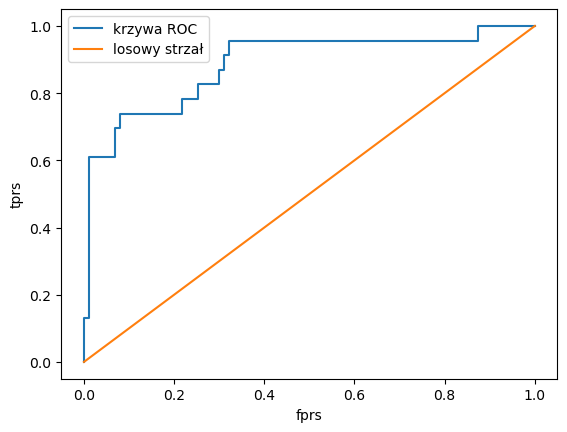

PyObject <matplotlib.legend.Legend object at 0x30d4c2b90>

In [32]:
y_pred = MLJ.predict(mach_tm, X_test)
fprs, tprs, ts = MLJ.roc(y_pred, y_test)
plot(fprs, tprs,fprs,fprs)
xlabel("fprs")
ylabel("tprs")
legend(("krzywa ROC", "losowy strzał"))

### AUC - Area under the ROC Curve

In [32]:
auc(y_pred, y_test)

0.8860569715142429